
## YKD unburned flux tower footprint ensembles
Updated 04/02/2022
SML

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpmath import gamma
from osgeo import gdal
from osgeo import osr
import rasterio as rio
import cartopy.crs as ccrs
import cartopy
import xarray as xr
from osgeo import gdalconst
from osgeo import gdal_array
%matplotlib inline

In [2]:
df=pd.read_csv('eddy_cov_C_fluxes_nofilter_YKD.csv',parse_dates=[1],na_values='NA',delimiter=' *, *',index_col=False)

C:\Users\Ludda\AppData\Local\Temp\ipykernel_17996\3889038252.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('eddy_cov_C_fluxes_nofilter_YKD.csv',parse_dates=[1],na_values='NA',delimiter=' *, *',index_col=False)


In [3]:
df.columns=df.columns.str.replace('.','_')

C:\Users\Ludda\AppData\Local\Temp\ipykernel_17996\1698892568.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns=df.columns.str.replace('.','_')


In [4]:
df=df.set_index('datetime')

Create a 1-dimensional footprint for the fluxes following the methods of Hsieh et al. 2000. First define stability metric $\zeta=z/L$: neutral conditions where |z/L|<0.02, stable where z/L>0.02, and unstable where z/L<-0.02. For this tower, z=2.5 m. 

In [5]:
zm=2.5
cp=1003 # J/K kg specific heat of air for constant pressure, 287 + gas constant of dry air J/kg K
df['Lcalc']=-(((df.air_pressure)/(287*(df.air_temperature+273)))*cp*(df.u_**3)*(273+df.air_temperature))/(0.41*9.8*df.H)
df['zeta']=zm/df.Lcalc
df['D']=np.ones_like(df.zeta)
df['P']=np.ones_like(df.zeta)
df['psi_m_H']=np.ones_like(df.zeta)
df['psi_m_zm']=np.ones_like(df.zeta)
df['psi_m_klj']=np.ones_like(df.zeta)

df['m']=np.ones_like(df.zeta)
df['n']=np.ones_like(df.zeta)
df['phi_m']=np.ones_like(df.zeta)
df['phi_c']=np.ones_like(df.zeta)

Define similarity constants D and P, and roughness length parameter psi_m based on stability metric:
D = 0.28; P = 0.59 for unstable condition,
D = 0.97; P = 1 for near neutral and neutral conditions,
D = 2.44; P = 1.33 for stable condition.


Determine stability correction factors psi_m (diabatic integration of wind profile (Paulson 1970)), phi_c (scalar eddy diffusivity), and phi_m (non-dimensional wind shear Dyer 1974) used for calculating surface roughness length (znot) and other constants under different atmospheric stability conditions:


If neutral, $$\psi_m =0$$


If stable, $$\psi_m = -5\zeta$$, $$\phi_c=\phi_m=1+5\zeta$$


If unstable, $$\psi_m = 2*log((1+x)/2)+log((1+x^2)/2)-2arctan(x)+\pi/2,  x = (1-16\zeta)^{0.25}$$
$$\phi_c=(1-16\zeta)^{-0.5}$$, $$\phi_m=(1-16\zeta)^{-0.25}$$



In [6]:
df['ex']=(1-16*df.zeta)**0.25
df['ex_klj']=(1-19*df.zeta)**0.25

df['psi_m_zm'] = np.where((df['Lcalc'] < 0),-2*np.log((1+df.ex)/2)-np.log((1+df.ex**2)/2)+2*np.arctan(df.ex)-np.pi/2, df['psi_m_zm']) 
df['psi_m_zm'] = np.where((df['Lcalc'] > 0), 5*df.zeta, df['psi_m_zm']) 

df['psi_m_klj'] = np.where((df['Lcalc'] > 0), -5.3*df.zeta, df['psi_m_klj']) 
df['psi_m_klj'] = np.where((df['Lcalc'] < 0), 2*np.log((1+df.ex_klj)/2)+np.log((1+df.ex_klj**2)/2)-2*np.arctan(df.ex_klj)+np.pi/2, df['psi_m_klj']) 

df['phi_c'] = np.where((df['Lcalc'] > 0), 1+5*df.zeta, df['phi_c']) 
df['phi_c'] = np.where(((df['Lcalc']) < 0), (1-16*df.zeta)**(-0.5), df['phi_c']) 
df['phi_m'] = np.where((df['Lcalc'] > 0), 1+5*df.zeta, df['phi_m']) 
df['phi_m'] = np.where(((df['Lcalc']) < 0), (1-16*df.zeta)**(-0.25), df['phi_m']) 

Define several other terms needed for calculating the footprint and fetch:

$$z_{not} = z_m/(exp(0.41* windspeed/u^*+\psi_m))$$
$$z_u=z_m*ln(z_m/z_{not})-1+z_{not}/z_m$$
$$\mu=(1+m)/r$$
$$\xi=U*(z_m)^r/(r^2*0.41)$$
$$r=2+m-n$$
$$windspeed=U*z_m^m$$
$$K=\kappa*z_m^n=0.41u_*z_m/\phi_c$$
$$m=u_*\phi_m/(0.41*windspeed)$$
$$n=1/(1+5\zeta)$$ for $$L>0$$
$$n=(1-24\zeta)/(1-16\zeta)$$ for $$L<0$$

In [7]:
# calculating znot (run once):

# neutral defined conservatively according to Hsieh as |zu/L|
# df_znot=df[df.zeta<0.02]
# df_znot=df_znot[df_znot.zeta>(-0.02)]
# df_znot['znot']=zm/np.exp(df_znot.wind_speed*0.41/df_znot.u_)
# df_znot.znot.describe() # mean is 0.0206, median is 0.00726, doesn't change much from using +/-0.02 or 0.04.
# df_znot.psi_m_zm.describe() # mean is 0.03, median is 0.03
# df.psi_m_zm.describe() #mean of whole dataset is 0.6, median is 1.
znot=0.0206

In [8]:
df['zu']=zm*(np.log(zm/znot)-1+znot/zm)
df['zeta_H']=df.zu/df.Lcalc
df['D'] = np.where((df['zeta_H'] < (-0.02)), 0.28, df['D']) 
df['D'] = np.where((df['zeta_H'] > 0.02), 2.44, df['D']) 
df['D'] = np.where((np.abs(df['zeta_H']) < 0.02), 0.97, df['D']) 
df['P'] = np.where((df['zeta_H'] < (-0.02)), 0.59, df['P']) 
df['P'] = np.where((df['zeta_H'] > 0.02), 1.33, df['P']) 
df['P'] = np.where((np.abs(df['zeta_H']) < 0.02), 1, df['P']) 

In [9]:
df['m']=df.u_*df.phi_m/(0.41*df.wind_speed)
df['n']=np.ones_like(df.zeta)
df['n'] = np.where((df['Lcalc'] > 0), 1/(1+5*df.zeta), df['n']) 
df['n'] = np.where(((df['Lcalc']) < 0), (1-24*df.zeta)/(1-16*df.zeta), df['n']) 
df['U']=df.wind_speed/(zm**df.m)
# df['U1']=(np.log(zm/znot)+df.psi_m_zm)*df.u_/(0.41*zm**df.m)
df['kappa']=0.41*df.u_*zm/(df.phi_c*zm**df.n)
df['r']=2+df.m-df.n
df['xi']=(df.U*zm**df.r)/(df.kappa*df.r**2)
df['mu']=(1+df.m)/df.r

Filter the dataset to pull only times when the wind is coming from the direction over the lake and there are good methane fluxes. Pick one time point to continue the footprint analysis

In [10]:
df2=df.reset_index()
df3=df2[df2.co2_flux.notnull()]
df3=df3[df3.Lcalc.notnull()]
df3=df3[df3.v_var.notnull()]
df3.shape

(18956, 32)

Predict the crosswind integrated footprint along dimension x up to the 90% fetch length for a given half hour block:
Following Hsieh et al. 2000:
$$Fy=(1/(x^2* 0.041^2))* D* {zu^P}* |L|^{1-P}* exp(-D* zu^P* |L|^{1-p}/(x* 0.41^2)$$
Following Karmann and Meixner 2001:
$$Fy=(1/\Gamma(\mu))(\xi^\mu/x^{1+\mu})e^{-\xi/x}$$


Extend the 1-D footprint into a 2-D footprint using the lateral dispersion, for a given half-hour:
Hsieh et al. 2000:
$$\sigma_y=(0.3* z_{not}* sqrt{\sigma_v}/u^*)* ((x/z_{not})^{0.86})$$
Forbich et al 2011 & Budischev et al. 2014 following Kormann and Meixner et al. 2001:
$$\sigma_y=sqrt{\sigma_v}*x/u^{-}$$
$$u^{-}=\Gamma(\mu)/\Gamma(1/r)*(\kappa r^2/U)^{m/r}*(Ux^{m/r})$$
For both: Gaussian crosswind distribution function (Pasquill 1974):
$$Dxy=(1/(\sqrt{2* \pi}* \sigma_y))* exp((-0.5)* ((y/\sigma_y)^2))$$
$$Fxy=Fy*Dxy$$

References for footprint models:
Hsieh C., G. Katul, T. Chi. 2000. Advances in water resources
Detto M., N. Montaldo, J. D. Albertson, M. Mancini, G. Katul. 2006. Water resources research
Kanda M., M. Kanega, T. Kawai, R. Moriwaki. 2007. American meteorlogical society
Sanz Rodrigo J., E. Cantero, B. Garcia, F. Borbon, U. Irigoyen, S. Lozano, P. M. Fernandes, R. A. Chavez. 2015. Journal of physics: conference series 625.
Businger J. A., J. C. Wyngaard, Y. Izumi, E. F. Bradley. 1971. Journal of atmospheric sciences
M. Golbanzi, C. L. Archer. 2019. Advances in meteorology.
R. Sozzi, M. Favaron. 1998. Journal of applied meteorology.

Create an array with lat long and georeference the footprint. The tower is located at 593402,6792413  in EPSG 32603, i.e. UTM 3N.

Turn the first footprint array into a raster for export.
Next the raster is loaded and shifted so the tower is at the correct placement.
Then it is re-gridded to the same ROI for all footprints and the landcover map.
Then it is masked by covertype, and patch influence sums are calculated.
Finally the rest of the dataset are looped through appending to create summarized footprint influence datasets

In [22]:
#### create subset for footprint making loop:
df4=df3[df3.datetime>'2019-07-20 11:00:00']
df4=df4[df4.datetime<'2019-07-20 12:00:00']

In [13]:
# For KM and Hsieh footprints

match_extent='landcover_footprint_extent.tif'
match_ds=gdal.Open(match_extent,gdalconst.GA_ReadOnly)
match_proj=match_ds.GetProjection()
match_gt=match_ds.GetGeoTransform()
wide=match_ds.RasterXSize
high=match_ds.RasterYSize
tower_y=6792413
tower_x=593402

for index,row in df4.iterrows():
    x=np.linspace(1,1000,1000)
    y=np.linspace(-250,250,500)
    xx,yy=np.meshgrid(x,y)
    Fy_H=(1/(0.41*0.41*x*x))*row.D*(row.zu**row.P)*(np.abs(row.Lcalc)**(1-row.P))*np.exp((-row.D*(row.zu**row.P)*(np.abs(row.Lcalc)**(1-row.P)))/(0.41*0.41*x))
    Fy_ZM=(1/(float(gamma(row.mu))))*(row.xi**row.mu)/(x**(1+row.mu))*np.exp(-row.xi/x)
    sigma_y_H=(0.3*znot*np.sqrt(row.v_var)/row.u_)*((xx/znot)**0.86)
    u_bar=float(gamma(row.mu))/(float(gamma(1/row.r)))*((row.kappa*(row.r**2)/row.U)**(row.m/row.r))*(row.U*(xx**(row.m/row.r)))
    sigma_y_ZM=np.sqrt(row.v_var)*xx/u_bar
    Dxy_H=(1/(np.sqrt(2*np.pi)*sigma_y_H))*np.exp((-0.5)*((yy/sigma_y_H)**2))
    Dxy_ZM=(1/(np.sqrt(2*np.pi)*sigma_y_ZM))*np.exp((-0.5)*((yy/sigma_y_ZM)**2))
    Fxy_ZM=Fy_ZM*Dxy_ZM
    Fxy_H=Fy_H*Dxy_H
    dist1=(xx**2+yy**2)**(0.5)
    angle1=np.arctan2(yy,xx)
    xx_rot1=dist1*np.sin(row.wind_dir*np.pi/180-angle1)
    yy_rot1=dist1*np.cos(row.wind_dir*np.pi/180-angle1)
    long1=xx_rot1+tower_x
    lat1=yy_rot1+tower_y
    ysize1 = lat1.shape[0]
    xsize1 = long1.shape[1]
    rotation1=(row.wind_dir+90)*np.pi/180
    xres=1
    yres=1
    ulx=tower_x
    uly=tower_y
    driver = gdal.GetDriverByName('GTiff')
    
    filenameH='%s_H.tif' %row.filename
    filenameZM='%s_ZM.tif' %row.filename
    srs = osr.SpatialReference()
    srs.ImportFromProj4('''+proj=utm +zone=3 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs''')
    gt1=[ulx,-xres*np.cos(rotation1),xres*np.sin(rotation1),uly,yres*np.sin(rotation1),yres*np.cos(rotation1)]

    dsH = driver.Create(filenameH, xsize1, ysize1, 1, gdal.GDT_Float32)
    dsH.SetProjection(srs.ExportToWkt())
    dsH.SetGeoTransform(gt1)
    outband = dsH.GetRasterBand(1)
    outband.WriteArray(Fxy_H)
    dsH = None
    
    dsZM = driver.Create(filenameZM, xsize1, ysize1, 1, gdal.GDT_Float32)
    dsZM.SetProjection(srs.ExportToWkt())
    dsZM.SetGeoTransform(gt1)
    outband = dsZM.GetRasterBand(1)
    outband.WriteArray(Fxy_ZM)
    dsZM = None
    
    footprintH=gdal.Open(filenameH, gdal.GA_Update)
    hyp=lat1.shape[0]/2
    cornerN=(row.wind_dir)*np.pi/180
    West=np.cos(cornerN)*hyp
    South=np.sin(cornerN)*hyp
    gt2 = footprintH.GetGeoTransform()
    gtl = list(gt2)
    gtl[3] += South
    gtl[0] -= West
    new_geotransform = gtl
    footprintH.SetGeoTransform(tuple(new_geotransform))
    footprintH = None
    
    footprintZM=gdal.Open(filenameZM, gdal.GA_Update)
    hyp=lat1.shape[0]/2
    cornerN=(row.wind_dir)*np.pi/180
    West=np.cos(cornerN)*hyp
    South=np.sin(cornerN)*hyp
    gt2 = footprintZM.GetGeoTransform()
    gtl = list(gt2)
    gtl[3] += South
    gtl[0] -= West
    new_geotransform = gtl
    footprintZM.SetGeoTransform(tuple(new_geotransform))
    footprintZM = None
    
    
    srcH=gdal.Open(filenameH,gdalconst.GA_ReadOnly)
    src_proj=srcH.GetProjection()
    src_gt=srcH.GetGeoTransform()
    renamedH='%s_ex_H.tif' %row.filename
    dstH=gdal.GetDriverByName('GTiff').Create(renamedH,wide,high,1,gdalconst.GDT_Float32)
    dstH.SetGeoTransform(match_gt)
    dstH.SetProjection(match_proj)
    gdal.ReprojectImage(srcH,dstH,src_proj,match_proj,gdalconst.GRA_Bilinear)
    del dstH
    
    srcZM=gdal.Open(filenameZM,gdalconst.GA_ReadOnly)
    src_proj=srcZM.GetProjection()
    src_gt=srcZM.GetGeoTransform()
    renamedZM='%s_ex_ZM.tif' %row.filename
    dstZM=gdal.GetDriverByName('GTiff').Create(renamedZM,wide,high,1,gdalconst.GDT_Float32)
    dstZM.SetGeoTransform(match_gt)
    dstZM.SetProjection(match_proj)
    gdal.ReprojectImage(srcZM,dstZM,src_proj,match_proj,gdalconst.GRA_Bilinear)
    del dstZM
    
   

In [14]:
# For Kljun outside of their functions

match_extent='landcover_footprint_extent.tif'
match_ds=gdal.Open(match_extent,gdalconst.GA_ReadOnly)
match_proj=match_ds.GetProjection()
match_gt=match_ds.GetGeoTransform()
wide=match_ds.RasterXSize
high=match_ds.RasterYSize
tower_y=6792413
tower_x=593402

# Model parameters
a_klj = 1.4524
b_klj = -1.9914
c_klj = 1.4622
d_klj = 0.1359
ac_klj = 2.17 
bc_klj = 1.66
cc_klj = 20.0

xstar_end = 30
oln = 5000 #limit to L for neutral scaling
k_klj = 0.4 #von Karman
nx=1000
z0=None
h_klj=1000

# Scaled X* for crosswind integrated footprint
xstar_ci_param = np.linspace(d_klj, xstar_end, nx+2)
xstar_ci_param = xstar_ci_param[1:]
# Crosswind integrated scaled F* 
fstar_ci_param = a_klj * (xstar_ci_param-d_klj)**b_klj * np.exp(-c_klj/ (xstar_ci_param-d_klj))
ind_notnan     = ~np.isnan(fstar_ci_param)
fstar_ci_param = fstar_ci_param[ind_notnan]
xstar_ci_param = xstar_ci_param[ind_notnan]

# Scaled sig_y*
sigystar_param = ac_klj * np.sqrt(bc_klj * xstar_ci_param**2 / (1 + cc_klj * xstar_ci_param))


for index,row in df4.iterrows():
    # wind drivers
    umean=row.wind_speed
    ol=row.L
    sigmav=np.sqrt(row.v_var)
    ustar=row.u_

    # Real scale x and f_ci
    if z0 is not None:
        # Use z0
        if ol <= 0 or ol >= oln:
            xx  = (1 - 19.0 * zm/ol)**0.25
            psi_f = np.log((1 + xx**2) / 2.) + 2. * np.log((1 + xx) / 2.) - 2. * np.arctan(xx) + np.pi/2
        elif ol > 0 and ol < oln:
            psi_f = -5.3 * zm / ol

        x_dim = xstar_ci_param * zm / (1. - (zm / h_klj)) * (np.log(zm / z0) - psi_f)
        if np.log(zm / z0) - psi_f > 0:
            x_ci = x_dim
            f_ci = fstar_ci_param / zm * (1. - (zm / h_klj)) / (np.log(zm / z0) - psi_f)
        else:
            x_ci_max, x_ci, f_ci, x_2d, y_2d, f_2d = None
    else:
        # Use umean if z0 not available
        x_dim = xstar_ci_param * zm / (1. - zm / h_klj) * (umean / ustar * k_klj)
        if umean / ustar > 0:
            x_ci = x_dim
            f_ci = fstar_ci_param / zm * (1. - zm / h_klj) / (umean / ustar * k_klj)
        else:
            x_ci_max, x_ci, f_ci, x_2d, y_2d, f_2d = None

    #Real scale sig_y
    if abs(ol) > oln:
        ol = -1E6
    if ol <= 0:   #convective
        scale_const = 1E-5 * abs(zm / ol)**(-1) + 0.80
    elif ol > 0:  #stable
        scale_const = 1E-5 * abs(zm / ol)**(-1) + 0.55
    if scale_const > 1:
        scale_const = 1.0
    sigy = sigystar_param / scale_const * zm * sigmav / ustar
    sigy[sigy < 0] = np.nan
                  
    #Real scale f(x,y)
    dx = x_ci[2] - x_ci[1]
    y_pos = np.arange(0, (len(x_ci) / 2.) * dx * 1.5, dx)
    f_pos = np.empty((len(f_ci), len(y_pos)))
    f_pos[:] = np.nan
    for ix in range(len(f_ci)):
        f_pos[ix,:] = f_ci[ix] * 1 / (np.sqrt(2 * np.pi) * sigy[ix]) * np.exp(-y_pos**2 / ( 2 * sigy[ix]**2))

    #Complete footprint for negative y (symmetrical)
    y_neg = - np.fliplr(y_pos[None, :])[0]
    f_neg = np.fliplr(f_pos)
    y_dim = np.concatenate((y_neg[0:-1], y_pos))
    f_dim = np.concatenate((f_neg[:, :-1].T, f_pos.T)).T

    #Matrices for output
    x_2d = np.tile(x_dim[:,None], (1,len(y_dim)))
    y_2d = np.tile(y_dim.T,(len(x_dim),1))
    f_2d = f_dim
    

    dist2=(x_2d**2+y_2d**2)**(0.5)
    angle2=np.arctan2(y_2d,x_2d)
    xx_rot2=dist2*np.sin(row.wind_dir*np.pi/180-angle2)
    yy_rot2=dist2*np.cos(row.wind_dir*np.pi/180-angle2)
    long2=xx_rot2+tower_x
    lat2=yy_rot2+tower_y
    ysize2 = lat2.shape[0]
    xsize2 = long2.shape[1]
    rotation2=(row.wind_dir)*np.pi/180
    xres=1
    yres=1
    ulx=tower_x
    uly=tower_y
    driver = gdal.GetDriverByName('GTiff')
 
    filenameKljun='%s_Kljun.tif' %row.filename
    srs = osr.SpatialReference()
    srs.ImportFromProj4('''+proj=utm +zone=3 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs''')
    gt2=[ulx,-xres*np.cos(rotation2),xres*np.sin(rotation2),uly,yres*np.sin(rotation2),yres*np.cos(rotation2)]

    
    dsKljun = driver.Create(filenameKljun, xsize2, ysize2, 1, gdal.GDT_Float32)
    dsKljun.SetProjection(srs.ExportToWkt())
    dsKljun.SetGeoTransform(gt2)
    outband = dsKljun.GetRasterBand(1)
    outband.WriteArray(f_2d)
    dsKljun = None
    
    footprintKljun=gdal.Open(filenameKljun, gdal.GA_Update)
    hyp=lat2.shape[1]/2
    cornerN=(row.wind_dir)*np.pi/180
    West=np.cos(cornerN)*hyp
    South=np.sin(cornerN)*hyp
    gt2 = footprintKljun.GetGeoTransform()
    gtl = list(gt2)
    gtl[3] -= South
    gtl[0] += West
    new_geotransform = gtl
    footprintKljun.SetGeoTransform(tuple(new_geotransform))
    footprintKljun = None
    
    src_Kljun=gdal.Open(filenameKljun,gdalconst.GA_ReadOnly)
    src_proj=src_Kljun.GetProjection()
    src_gt=src_Kljun.GetGeoTransform()
    renamed_Kljun='%s_ex_Kljun.tif' %row.filename
    dst_Kljun=gdal.GetDriverByName('GTiff').Create(renamed_Kljun,wide,high,1,gdalconst.GDT_Float32)
    dst_Kljun.SetGeoTransform(match_gt)
    dst_Kljun.SetProjection(match_proj)
    gdal.ReprojectImage(src_Kljun,dst_Kljun,src_proj,match_proj,gdalconst.GRA_Bilinear)
    del dst_Kljun

First create mask for full extent, then load full footprint extents.

(241, 611)


Text(0, 0.5, 'y')

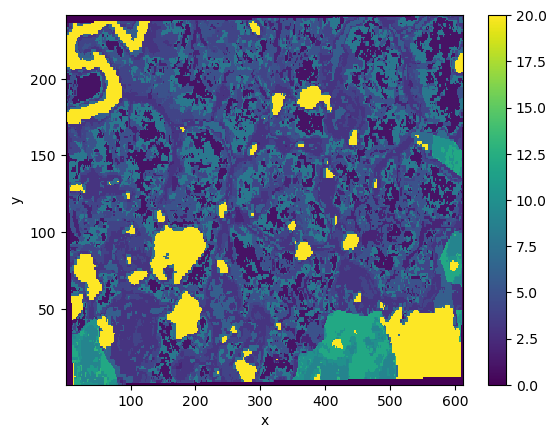

In [15]:
image_name='landcover_footprint_extent.tif'
landcover_array=gdal_array.LoadFile(image_name)
print(landcover_array.shape)
landcover_vect=landcover_array.reshape((611*241))
test_y=np.linspace(1,241,241)
test_x=np.linspace(1,611,611)
test_xx,test_yy=np.meshgrid(test_x,test_y)
plotr=plt.pcolormesh(test_xx,test_yy,landcover_array)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

In [16]:
# Create masks based on landcover:
landcover_mask=dict()
for index in range(0,21):
    landcover_mask[index]=np.ma.masked_where((landcover_vect==index),landcover_vect)


In [20]:
# Running it in 3 blocks of 5,000 observations since takes about half an hour per 5,000.
# change range in iloc for defining df4 and name of csv export when running in batches
# df4=df3.iloc[0:5000]

# for Kljun footprint extents:

# load footprints, unwrap, mask by landcovers, and summarize into an array:
G_patch=np.zeros((1,21),dtype=float)
for index,row in df4.iterrows():
    image_name='%s_ex_Kljun.tif' %row.filename
    dst_array_loop=gdal_array.LoadFile(image_name)
    dst_row_loop=(dst_array_loop.reshape((611*241)))/np.sum(dst_array_loop)
    ftp_masked=dict()
    ftp_sums_loop=np.zeros((1,21),dtype=float)
    for itera in range(1,21):
        ftp_masked[itera]=np.ma.masked_array(dst_row_loop,mask=np.invert(np.ma.getmask(landcover_mask[itera])))
        ftp_class_sum=np.sum(ftp_masked[itera])
        ftp_sums_loop[0,itera]=ftp_class_sum
    G_patch=np.vstack((G_patch,ftp_sums_loop))
G_patch=G_patch[1:,:]

# write out array with attached filenames and dates from the eddy covariance fluxes
df4.reset_index(drop=True, inplace=True)
cover_type_num=np.linspace(1,G_patch.shape[1],G_patch.shape[1])
res = list(map(int, cover_type_num))
cover_names=list(map(str,res))
G_patch_df=pd.DataFrame(G_patch,columns=cover_names)
G_patch_df.reset_index(drop=True, inplace=True)
G_patch_df2=pd.concat([df4.filename,df4.datetime,G_patch_df],axis=1)
G_patch_df2.to_csv('footprint_influence_sums_Kljun_dateversion_0-5000obs.csv')


C:\Users\Ludda\AppData\Local\Temp\ipykernel_17996\3667247223.py:18: UserWarning: Warning: converting a masked element to nan.
  ftp_sums_loop[0,itera]=ftp_class_sum


In [23]:
# Running it in 3 blocks of 5,000 observations since takes about half an hour per 5,000.
# change range in iloc for defining df4 and name of csv export when running in batches
# df4=df3.iloc[0:5000]

# for Hsieh footprint extents:

# load footprints, unwrap, mask by landcovers, and summarize into an array:
G_patch=np.zeros((1,21),dtype=float)
for index,row in df4.iterrows():
    image_name='%s_ex_H.tif' %row.filename
    dst_array_loop=gdal_array.LoadFile(image_name)
    dst_row_loop=(dst_array_loop.reshape((611*241)))/np.sum(dst_array_loop)
    ftp_masked=dict()
    ftp_sums_loop=np.zeros((1,21),dtype=float)
    for itera in range(1,21):
        ftp_masked[itera]=np.ma.masked_array(dst_row_loop,mask=np.invert(np.ma.getmask(landcover_mask[itera])))
        ftp_class_sum=np.sum(ftp_masked[itera])
        ftp_sums_loop[0,itera]=ftp_class_sum
    G_patch=np.vstack((G_patch,ftp_sums_loop))
G_patch=G_patch[1:,:]

# write out array with attached filenames and dates from the eddy covariance fluxes
df4.reset_index(drop=True, inplace=True)
cover_type_num=np.linspace(1,G_patch.shape[1],G_patch.shape[1])
res = list(map(int, cover_type_num))
cover_names=list(map(str,res))
G_patch_df=pd.DataFrame(G_patch,columns=cover_names)
G_patch_df.reset_index(drop=True, inplace=True)
G_patch_df2=pd.concat([df4.filename,df4.datetime,G_patch_df],axis=1)
G_patch_df2.to_csv('footprint_influence_sums_Hsieh_dateversion_0-5000obs.csv')


C:\Users\Ludda\AppData\Local\Temp\ipykernel_17996\3542020396.py:18: UserWarning: Warning: converting a masked element to nan.
  ftp_sums_loop[0,itera]=ftp_class_sum


In [24]:
# Running it in 3 blocks of 5,000 observations since takes about half an hour per 5,000.
# change range in iloc for defining df4 and name of csv export when running in batches
# df4=df3.iloc[0:5000]

# for Kormann & Meixner  footprint extents:

# load footprints, unwrap, mask by landcovers, and summarize into an array:
G_patch=np.zeros((1,21),dtype=float)
for index,row in df4.iterrows():
    image_name='%s_ex_ZM.tif' %row.filename
    dst_array_loop=gdal_array.LoadFile(image_name)
    dst_row_loop=(dst_array_loop.reshape((611*241)))/np.sum(dst_array_loop)
    ftp_masked=dict()
    ftp_sums_loop=np.zeros((1,21),dtype=float)
    for itera in range(1,21):
        ftp_masked[itera]=np.ma.masked_array(dst_row_loop,mask=np.invert(np.ma.getmask(landcover_mask[itera])))
        ftp_class_sum=np.sum(ftp_masked[itera])
        ftp_sums_loop[0,itera]=ftp_class_sum
    G_patch=np.vstack((G_patch,ftp_sums_loop))
G_patch=G_patch[1:,:]

# write out array with attached filenames and dates from the eddy covariance fluxes
df4.reset_index(drop=True, inplace=True)
cover_type_num=np.linspace(1,G_patch.shape[1],G_patch.shape[1])
res = list(map(int, cover_type_num))
cover_names=list(map(str,res))
G_patch_df=pd.DataFrame(G_patch,columns=cover_names)
G_patch_df.reset_index(drop=True, inplace=True)
G_patch_df2=pd.concat([df4.filename,df4.datetime,G_patch_df],axis=1)
G_patch_df2.to_csv('footprint_influence_sums_ZM_dateversion_0-5000obs.csv')


C:\Users\Ludda\AppData\Local\Temp\ipykernel_17996\950449175.py:18: UserWarning: Warning: converting a masked element to nan.
  ftp_sums_loop[0,itera]=ftp_class_sum
